Aproveitei parte do código já disponibilizado no notebook:


In [ ]:
# Common imports
import numpy as np
import pandas as pd 
import os


# Para ajudar na reproducibilidade
# Aqui a seed é 42, mas não há nada de especial nisso
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_id, format='png', dpi=600)

In [ ]:
#Importando dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#Embaralhemento 
shuffle_index = np.random.permutation(60000)
#VANDERVAL: Tive que adicionar ".to_numpy()" para que o código executasse.
X_train, y_train = X_train.to_numpy()[shuffle_index], y_train[shuffle_index]

Aqui começa a atividade requisitada. Montei uma função que rotaciona a imagem 90 graus no sentido anti-horário:


In [ ]:
def rotate_image_90degrees_anticlockwise(data):
  #gira a imagem 90º no sentido anti-horário
  data = data.reshape((28, 28))
  translated_image = np.zeros((28,28))
  for i in range (28):
    translated_image[:, i] = np.flip(data[i, :])
  return translated_image


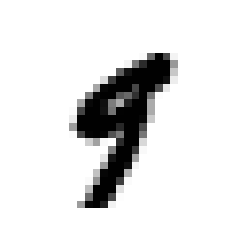

In [ ]:
#Imagem original:
plot_digit((X.to_numpy()[36000]))

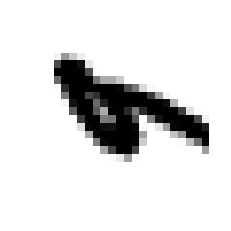

In [ ]:
#Imagem rotacionada 90º no sentido antihorário
plot_digit(rotate_image_90degrees_anticlockwise(X.to_numpy()[36000]))

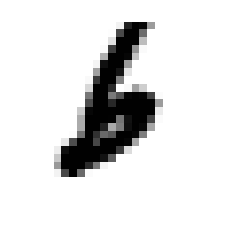

In [ ]:
#Imagem rotacionada 180º no sentido antihorário
plot_digit(rotate_image_90degrees_anticlockwise(rotate_image_90degrees_anticlockwise(X.to_numpy()[36000])))

A seguir, temos uma função que translada a imagem:

In [ ]:
def translate_image(data, vertical, number):
  #Translada a imagem na vertical ou na horizontal de acordo com o numéro de pixels "number"
  #Translada para baixo [esquerda] se number < 0, e translada para cima [direita] se number > 0.
  data = data.reshape((28, 28))
  translated_image = np.zeros((28,28))
  if (number >= 0):
    if (vertical):    
      for i in range (28 - number):
        translated_image[i + number, :] = data[i, :]
      return translated_image
    else:
      for i in range (28 - number):
        translated_image[:, i + number] = data[:, i]
      return translated_image
  else:
    if (vertical):    
      data = np.vstack((data, np.zeros((abs(number), 28))))
      for i in range (28 - abs(number)):
        translated_image[i :] = data[i + abs(number), :]
      return translated_image
    else:
      data = np.c_[data, np.zeros((28, abs(number)))]
      for i in range (28 - abs(number)):
        translated_image[:, i] = data[:, i + abs(number)]
      return translated_image


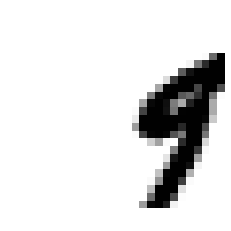

In [ ]:
#Imagem transladada 8 pixels para a direita
plot_digit(translate_image(X.to_numpy()[36000], False,  8))

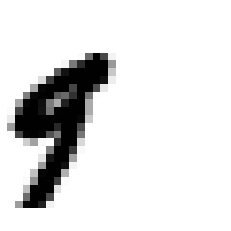

In [ ]:
#Imagem transladada 8 pixels para a esquerda
plot_digit(translate_image(X.to_numpy()[36000], False, -8))

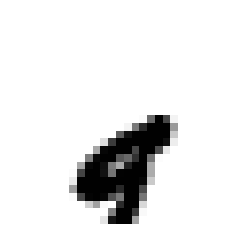

In [ ]:
#Imagem transladada 8 pixels para baixo
plot_digit(translate_image(X.to_numpy()[36000], True,   8))

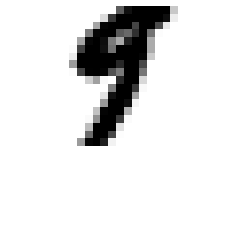

In [ ]:
#Imagem transladada 8 pixels para cima
plot_digit(translate_image(X.to_numpy()[36000], True,  -8))

Começaremos a criar o nosso novo conjunto de treino, transladando os dados de treino originais

In [ ]:
#Cria os dados de treino transladados
X_train_transladados = [image for image in X_train]
y_train_transladados = [label for label in y_train]

#Adicionei translações para cima, baixo, direita e esquerda. Também poderia tentar adicionar rotações.
for image, label in zip(X_train, y_train):
  X_train_transladados.append(translate_image(image, False,   1).reshape([-1])) #Precisa dar reshape pq a função translate_imagem retorna um np.array 28x28
  X_train_transladados.append(translate_image(image, False,  -1).reshape([-1]))
  X_train_transladados.append(translate_image(image, True,    1).reshape([-1]))
  X_train_transladados.append(translate_image(image, True,   -1).reshape([-1]))
  y_train_transladados.append(label) #Bota o label 4 vezes, uma para cada translação
  y_train_transladados.append(label)
  y_train_transladados.append(label)
  y_train_transladados.append(label)

#Transforma as listas em array
X_train_transladados = np.array(X_train_transladados)
y_train_transladados = np.array(y_train_transladados)

Embaralha os dados:

In [ ]:
#Embaralhemento 
shuffle_index = np.random.permutation(60000)
#VANDERVAL: Tive que adicionar ".to_numpy()" para que o código executasse.
X_train_transladados, y_train_transladados = X_train_transladados[shuffle_index], y_train_transladados[shuffle_index]

Agora, usaremos o GridSearchCV para encontrar os melhores parâmetros, e treinaremos o modelo no conjunto de dados de treino transladados

In [ ]:
from sklearn.linear_model import SGDClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline #Para criar um pipeline!
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ]) #O nosso modelo passará pelo std_scaler e depois pelo estimador

#Usaremos 10 epochs, por isso max_iter = 10 
#Cuidado, valores alto de max_iter fazem o algortirmo demorar
#Outros valores para max_iter ou random_state, vão alterar o resultado

param_grid = [{'estimator__loss' : ['hinge', 'log'],
               'estimator__alpha': [1e-4, 1e-2, 1],
               }] #grade de parâmetros para testar

grid_search_transladados = GridSearchCV(pipe, param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search_transladados.fit(X_train_transladados, y_train_transladados)

model_transladados = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 1000, random_state=42))
             ])

model_transladados.set_params(**grid_search_transladados.best_params_) 

model_transladados.fit(X_train_transladados, y_train_transladados)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('estimator', SGDClassifier(random_state=42))])

Vamos usar o OneVsOne no SGDClassifier ao invés de OvR:

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf_transladados = OneVsOneClassifier(model_transladados)
ovo_clf_transladados.fit(X_train_transladados, y_train_transladados)

OneVsOneClassifier(estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('estimator',
                                              SGDClassifier(random_state=42))]))

Podemos analisar os resultados da predição através da matriz de confusão:

In [ ]:
from sklearn.metrics  import confusion_matrix

y_pred = ovo_clf_transladados.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but OneVsOneClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[ 946,    0,    8,    4,    2,   12,    5,    2,    1,    0],
       [   0, 1104,   12,    4,    0,    1,    2,    3,    9,    0],
       [   5,    3,  962,   19,    3,    4,    7,    6,   21,    2],
       [   1,    0,   18,  929,    1,   24,    2,    5,   25,    5],
       [   1,    1,   13,    3,  924,    0,    4,    6,    8,   22],
       [   9,    0,    6,   40,    5,  787,   10,    2,   29,    4],
       [   9,    3,   21,    3,    5,   20,  895,    0,    2,    0],
       [   0,    2,   28,   20,    4,    1,    1,  948,    4,   20],
       [   6,    2,   12,   35,    7,   26,    6,    6,  861,   13],
       [   6,    6,    5,   13,   34,    6,    0,   34,   12,  893]])

Por último, vamos verificar a acurácia:

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9249